### How long should people infected with the virus isolate for? Possible steps to answer this are:
- Find all terms that describe isolation (incubation, quarantine, isolation, infectious, transmissable, spreading, transferable, contagious)
- Look for all numbers used near these words (in the form 'XX days') that describe the recommend isolation period.
- Put all numbers into a list and average them to determine the recommended isolation period.
- Spot check a few examples to check it's working as expected.

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords=set(nltk.corpus.stopwords.words('english'))
from collections import defaultdict

### Import data and return english sentences

In [2]:
data = pd.read_csv("Data/clean_pmc.csv", nrows=10000)

In [26]:
data.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,14572a7a9b3e92b960d92d9755979eb94c448bb5,Immune Parameters of Dry Cows Fed Mannan Oligo...,"S T Franklin, M C Newman, K E Newman, K I Meek","S T Franklin (University of Kentucky, 40546-02...",Abstract\n\nThe objective of this study was to...,INTRODUCTION\n\nThe periparturient period is a...,Immune response of pregnant heifers and cows t...,"[{'first': 'S', 'middle': ['T'], 'last': 'Fran...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Immune ..."
1,bb790e8366da63c4f5e2d64fa7bbd5673b93063c,Discontinuous Transcription or RNA Processing ...,"Beate Schwer, Paolo Vista, Jan C Vos, Hendrik ...","Beate Schwer, Paolo Vista, Jan C Vos, Hendrik ...",NaN,Discontinuous\n\nTranscription or RNA Processi...,Poly (riboadenylic acid) preferentially inhibi...,"[{'first': 'Beate', 'middle': [], 'last': 'Sch...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Poly (r..."
2,24f204ce5a1a4d752dc9ea7525082d225caed8b3,NaN,NaN,NaN,NaN,Letter to the Editor\n\nThe non-contact handhe...,Novel coronavirus is putting the whole world o...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'Novel c..."
3,f5bc62a289ef384131f592ec3a8852545304513a,Pediatric Natural Deaths 30,"Elizabeth C Burton, Nicole A Singer",Elizabeth C Burton (Johns Hopkins University S...,NaN,"Introduction\n\nWorldwide, the leading causes ...",In athletes who experienced sudden death or in...,"[{'first': 'Elizabeth', 'middle': ['C'], 'last...","{'BIBREF0': {'ref_id': 'b0', 'title': 'In athl..."
4,ab78a42c688ac199a2d5669e42ee4c39ff0df2b8,A real-time convective PCR machine in a capill...,"Yi-Fan Hsieh, Da-Sheng Lee, Ping-Hei Chen, Sha...","Yi-Fan Hsieh (National Taiwan University, 106,...","Abstract\n\nThis research reports the design, ...",Introduction\n\nMullis et al. developed the po...,"The Polymerase Chain Reaction, K B Mullis, F F...","[{'first': 'Yi-Fan', 'middle': [], 'last': 'Hs...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The Pol..."


In [3]:
data_cleaned = data[data['text'].apply(lambda x: bool(re.match('.*[a-zA-Z]+', x)))]
lang = pd.read_csv("Data/predicted_lang_10k.csv", index_col=0).squeeze()
data_eng = data_cleaned[lang == 'en']
# reset index for use in pd.iterrows()
data_eng = data_eng.reset_index()

### Define functions to determine recommended isolation period

In [4]:
def extract_days(tokenized_sent, anchor_word='days', days_regex="[0-9.]+"):
    
    # find index position of anchor word in sentence
    anchor_pos = tokenized_sent.index(anchor_word)
    days=[]

    # search for the two words preceding the anchor word and check
    # if they are numbers (using days_regex to confirm). If so, add
    # them to `days` list and take average. This is useful if a range
    # has been given. e.g. 2-6 days will return 4 days.
    for i in [anchor_pos-2, anchor_pos-1]:
        if i >= 0 and bool(re.match(days_regex, tokenized_sent[i])):
            day = re.findall(days_regex, tokenized_sent[i])
            days.extend(day)

    if days == []:
        return None
    else:
        try:
            np.asarray(days, dtype=np.float32).mean()
        except:
            print(f"Days list {days} can't be converted to numpy array. Extracted from {tokenized_sent}")
        else:
            return np.asarray(days, dtype=np.float32).mean()

In [5]:
def recommended_isolation(data, keywords, anchor_word='days', subset=None, threshold=34):

    # take subset of data to avoid long run time if requested by user
    if subset is not None:
        data = data[:subset]

    isolation=[]
    index=[]
    keyword_counter = defaultdict(int)
    
    # loop through pandas dataframe
    for indx, row in data.iterrows():
        # split 'text' column into sentences
        sents = sent_tokenize(row['text'])
        # split those sentences into words
        words = [word_tokenize(sent) for sent in sents]
        # loop through list of lists where outer list is each sentence and
        # inner list is each word in that sentence. Convert to lower text
        # and remove stopwords. Then extract the no. of days from each sentence
        # that contains a keyword(s).
        for sent in words:
            sent_clean = [word.lower() for word in sent if word.lower() not in stopwords]
            keywords_present = [word for word in keywords if word in sent_clean]
            if len(keywords_present) > 0 and anchor_word in sent_clean:
                days_from_sent = extract_days(sent_clean)
                if days_from_sent is not None and days_from_sent < threshold:
                    isolation.append(days_from_sent)
                    index.append(indx)
                    for keyword_present in keywords_present:
                        keyword_counter[keyword_present] += 1
            
    return isolation, index, keyword_counter

### Run word2vec to determine keywords

In [6]:
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
tqdm.pandas()

c:\Users\charl\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
corpus=[]
for index, row in tqdm(data_eng.iterrows(), total=data_eng.shape[0]):
    words = word_tokenize(row['text'])
    words_cleaned = [word.lower() for word in words if word.lower() not in stopwords]
    corpus.append(words_cleaned)

100%|██████████| 6427/6427 [13:11<00:00,  8.12it/s] 


In [8]:
model = Word2Vec(sentences=corpus)

In [9]:
model.save("Data/word2vec_embeddings_10k.model")

In [36]:
model.wv.most_similar('caws')

[('intravitreal', 0.7313181161880493),
 ('i.t', 0.6864265203475952),
 ('qingkailing', 0.6757372617721558),
 ('intraperitoneal', 0.6621809601783752),
 ('rhcat', 0.6610978841781616),
 ('aav6-hserca2a', 0.6581068634986877),
 ('cpg-odn', 0.656329333782196),
 ('pha-p', 0.6558051705360413),
 ('carrageenan', 0.6556609869003296),
 ('adv-pk15', 0.6544021964073181)]

### Define keywords and run functions

In [6]:
keywords = ['quarantine', 'quarantining', 'quarantined', 'containment', 'notification', 'precautionary', 'quarantines', 'precautions', 'compulsory', 'tracing', 'precaution']
days_to_isolate = recommended_isolation(data_eng, keywords=keywords, subset=5000)

In [7]:
a = np.asarray(days_to_isolate[0], dtype=np.float32)
print(f'Median recommended isolation: {np.median(a)} days')
print(f'Number of keywords found: {len(days_to_isolate[0])}')

Median recommended isolation: 10.0 days
Number of keywords found: 75


### Error analysis

In [8]:
import matplotlib.pyplot as plt

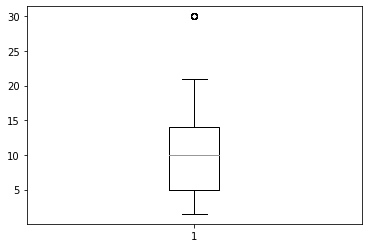

In [9]:
result = plt.boxplot(a)
plt.show()

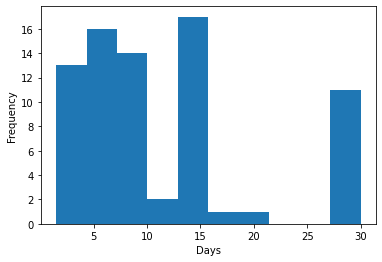

In [10]:
plt.hist(a)
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

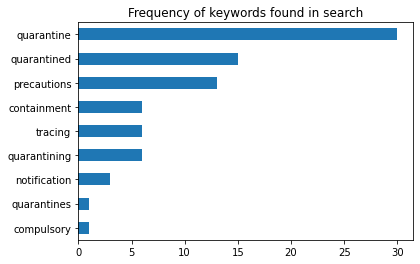

In [11]:
df = pd.DataFrame(days_to_isolate[2].items(), columns=['keyword', 'frequency'])
df = df.sort_values('frequency', ascending=True)
df.plot(x='keyword', y='frequency', kind='barh', legend=False)
plt.title('Frequency of keywords found in search')
plt.ylabel('')
plt.show()

In [13]:
print("Day", "Index", "\n---------")
for day, index in zip(days_to_isolate[0], days_to_isolate[1]):
    print(day, index)

Day Index 
---------
14.0 22
4.6 22
14.0 22
30.0 89
5.0 243
14.5 243
21.0 243
3.0 426
5.0 426
5.0 426
14.0 657
14.0 657
8.0 657
7.0 673
30.0 728
14.0 876
3.0 968
7.0 974
2.5 981
30.0 1029
30.0 1029
3.5 1051
10.0 1086
3.0 1126
7.0 1126
14.0 1270
7.0 1365
10.5 1495
4.4 1528
30.0 1617
10.0 1617
14.0 1617
14.0 1856
14.0 1856
14.0 1856
5.0 2104
30.0 2209
3.0 2406
10.0 2477
10.0 2564
10.0 2691
14.0 2769
10.0 3021
5.0 3060
14.0 3071
17.0 3146
1.5 3263
7.0 3397
14.0 3397
7.0 3397
30.0 3478
30.0 3501
10.0 3640
9.0 3704
10.0 3704
3.0 3779
2.0 3779
10.0 3779
2.0 3779
10.0 3779
14.0 3906
7.0 4050
10.0 4211
30.0 4250
3.0 4306
3.0 4306
5.5 4402
30.0 4460
1.5 4500
11.0 4527
14.0 4550
10.0 4600
30.0 4932
15.0 4932
5.0 4967


In [114]:
print(data_eng.iloc[678, 6])